# Laboratorium

### Konfiguracja

In [8]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js


# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [9]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


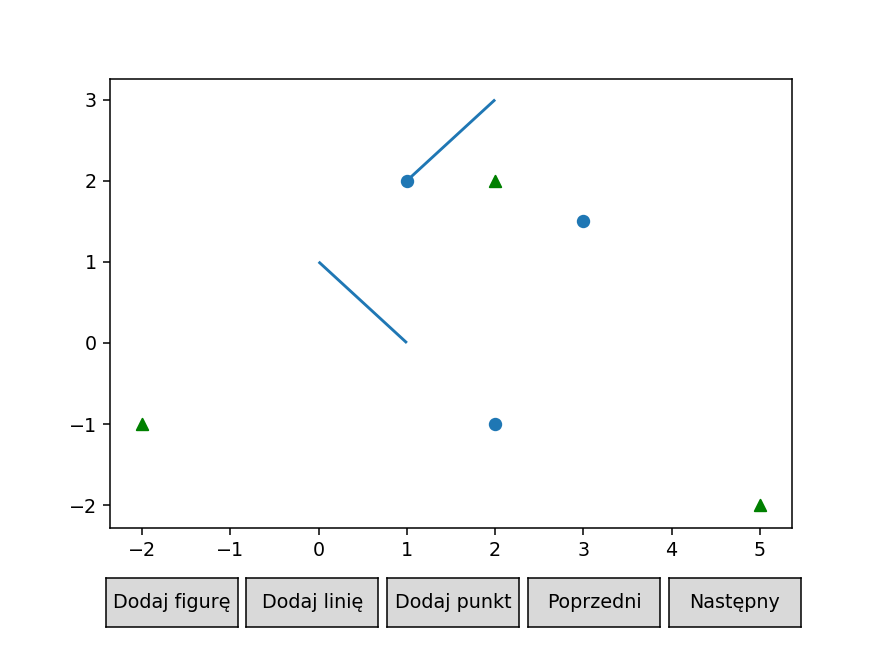

In [6]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

<IPython.core.display.Javascript object>


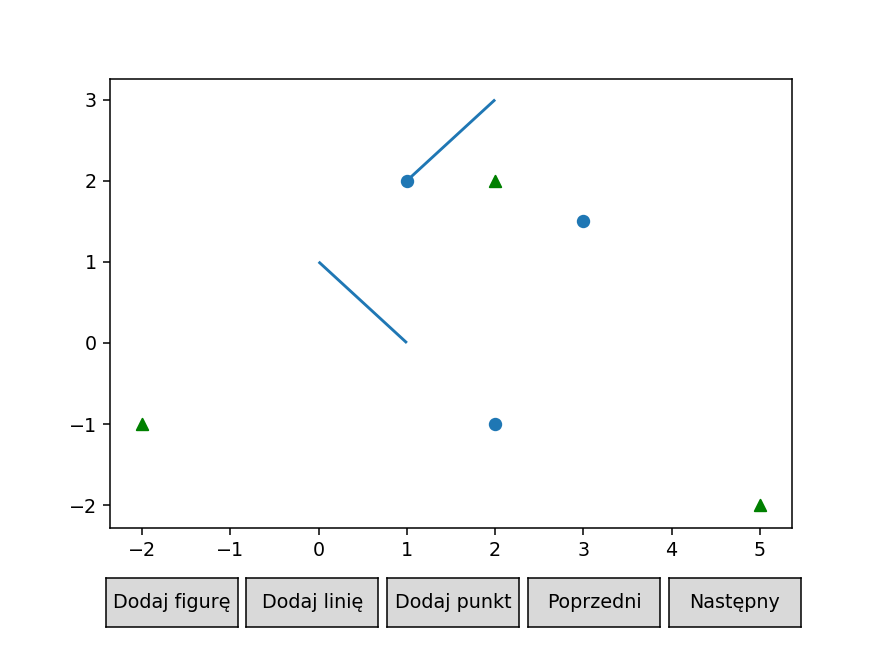

In [57]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [ ]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [4]:
%matplotlib notebook
import random
import math
import numpy as np
import csv

#DOMINIKA KWASNIEWSKA
#ROZWIAZANIE

#Zmienne, na podstawie ktorych okreslane beda generowane zbiory punktow

#A
nA = 100
nStart = -100
nEnd = 100

#B
nB = 100
r = 10
sX = 0
sY = 0

#C
nC = 100
w1C = [-10,-10]
w2C = [10,10]

#D
nside = 25
ndiag = 20
w1D = [2,3]
w2D = [5,6]

#Funkcje generujace zbiory punktow

def generatePointsA(nA,nStart,nEnd):
    pointsA = []

    for i in range (nA):
        x = random.uniform(nStart,nEnd)
        y = random.uniform(nStart,nEnd)
        pointsA.append([x,y])
        
    return pointsA
    

def generatePointsB(nB,r,sX,sY):
    
    pointsB = []   

    for i in range (nB):
        t = random.uniform(0,2*math.pi)
        x = r * math.sin(t)+sX
        y = r * math.cos(t)+sY
        pointsB.append([x,y])
        
    return pointsB
    
def generatePointsC(nC,w1C,w2C):
    pointsC = []
    for i in range (nC):
        x = random.randint(1,4)
        coX = random.uniform(w1C[0],w2C[0])
        coY = random.uniform(w1C[1],w2C[1])
        if x == 1:
            pointsC.append([w1C[0],coY])
        elif x == 2:
            pointsC.append([w2C[0],coY])
        elif x == 3:
            pointsC.append([coX,w1C[1]])
        elif x == 4:
            pointsC.append([coX,w2C[1]])
        
    return pointsC
        
def generatePointsD(nside,ndiag,w1D,w2D):
    pointsD = [w1D,[w2D[0],w1D[1]],[w1D[0],w2D[1]],w2D]

    for i in range (nside):
        y = random.uniform(w1D[1],w2D[1])
        pointsD.append([w1D[0],y])
    
    for i in range (nside):
        x = random.uniform(w1D[0],w2D[0])
        pointsD.append([x,w1D[1]])
    
    for i in range (ndiag):
        x = random.uniform(w1D[0],w2D[0])
        pointsD.append([x,x+w1D[1]-w1D[0]])
    
    for i in range (ndiag):
        x = random.uniform(w1D[0],w2D[0])
        pointsD.append([x,-x+w2D[1]+w1D[0]])
        
    return pointsD

pointsA = generatePointsA(nA,nStart,nEnd)
pointsB = generatePointsB(nB,r,sX,sY)
pointsC = generatePointsC(nC,w1C,w2C)
pointsD = generatePointsD(nside,ndiag,w1D,w2D)
    
#wyznacznik 3x3 wlasny, wniosek z 1. laboratorium
#do oznaczania punktow wspolliniowych wykorzystana bedzie tolerancja rowniez okreslona na laboratorium 1

epsilon = 10**(-10)

def cross_prod(a,b,c):
    [ax,ay] = a
    [bx,by] = b
    [cx,cy] = c
    
    det = (ax*by + bx*cy + ay*cx) - (by*cx + ay*bx + cy*ax)
    
    return det

#funkcja okreslajaca odleglosc miedzy punktami p0 oraz p

def distanceBetweenPoints(p0,p):
    return ((p[0]-p0[0])**2 + (p[1] - p0[1])**2)**(1/2)


#Do sortowania punktow wykorzystano wlasna implementacje algorytmu quicksort wykorzystujaca funkcje cross_prod
#do okreslania polozenia punktow wzgledem siebie

def partition(A,p,r,p0):
    x = A[r]
    i = p-1
    for j in range(p,r):
        if cross_prod(p0,A[j],x) > 0:            
            i+=1
            A[i],A[j] = A[j],A[i]
    A[i+1],A[r] = A[r], A[i+1]
    return i+1

def Quicksort(A,p,r,p0):
    if p < r:
        q = partition(A,p,r,p0)
        Quicksort(A,p,q-1,p0)
        Quicksort(A, q+1,r,p0)      
        

#Implementacja algorytmu Grahama

def Graham(points):
    #szukanie punktu o najmniejszej wspolrzednej y (i x)
    p0 = points[0]
    for point in points:
        if p0[1] > point[1]:
            p0 = point
        elif p0[1] == point[1] and p0[0] > point[0]:
            p0 = point
    
    #usuniecie punktu z listy
    points.remove(p0)

    #sortowanie pozostalych punktow ze wzgledu na wielkosc kata
    Quicksort(points,0,len(points)-1,p0)
    
    #usuniecie punktow o takiej samej wartosci kata i mniejszej odleglosci
    i = 0
    j = 1
    remove = [] #przechowywanie indeksow do usuniecia
    
    #znalezienie punktow tworzacych ten sam kat
    while(j<len(points)):
        prod = cross_prod(p0,points[i],points[j]) 
        if prod <= (epsilon) and prod >= -(epsilon):
            if distanceBetweenPoints(p0,points[i]) >= distanceBetweenPoints(p0,points[j]):
                remove.append(j)
                j+=1
            else:
                remove.append(i)
                i = j
                j+=1
        else:
            i = j
            j+=1
                
   
    points = [ i for j, i in enumerate(points) if j not in remove] #usuniecie punktow po indeksie
        
    #pusty stack
    stack = []
    
    #do stacka dajemy punkt p0 i 2 poczatkowe punkty
    stack.append(p0)
    stack.append(points[0])
    stack.append(points[1])
    
    i = 2
     
    while(i < len(points)):
        if cross_prod(stack[len(stack)-1],stack[len(stack)-2],points[i]) < -epsilon:  #jezeli wyznacznik jest mniejszy od "zera"
            stack.append(points[i])
            i+=1
        else:
            stack.pop()
    
    return stack #zwracamy obecna zawartosc stosu


#Funkcja umozliwiajaca porownanie punktow stawiajaca priorytet na wspolrzedna y (szukamy punktu najnizej, jezeli jest wiecej niz jeden to tez najbardziej na lewo)
def comp(x):
    return x[1]*100000 + x[0]  


#Implementacja algorytmu Jarvisa
def Jarvis(points):
    #szukanie punktu o najmniejszej wspolrzednej y (i x)
    p0 = min(points, key = lambda x: comp(x))
    i0 = points.index(p0)
    
    i = i0 #indeks
    
    
    Hull = [p0]
    
    while True:
        k = (i+1) % len(points)
        
        for j in range (len(points)):   #for j ≠ i do
            
            if j == i:
                continue
            #szukamy punkt, dla którego kąt liczony przeciwnie do
            #wskazówek zegara w odniesieniu do ostatniej krawędzi
            #otoczki jest najmniejszy
            
            prod = cross_prod(points[i], points[j], points[k])
            if prod > epsilon or (prod <= epsilon and prod >= -epsilon and distanceBetweenPoints(points[j], points[i]) > distanceBetweenPoints(points[k], points[i])):
                k = j
            
        i = k
        
        if i == i0:
            break
        
        Hull.append(points[k])
        
    return Hull




#Funkcja umozliwiajaca zapis do pliku csv dowolnego wyniku

def writeThisDown(points,function): #przyjmuje zbior punktow oraz funkcje (Jarvis/Graham)

    list = function(points)

    with open ("wynik.csv",'w') as handle:
        
        csvwriter = csv.writer(handle)
        csvwriter.writerow(list)     #zapis do pliku otrzymanej listy punktow nalezacych do otoczki
        
    



<IPython.core.display.Javascript object>


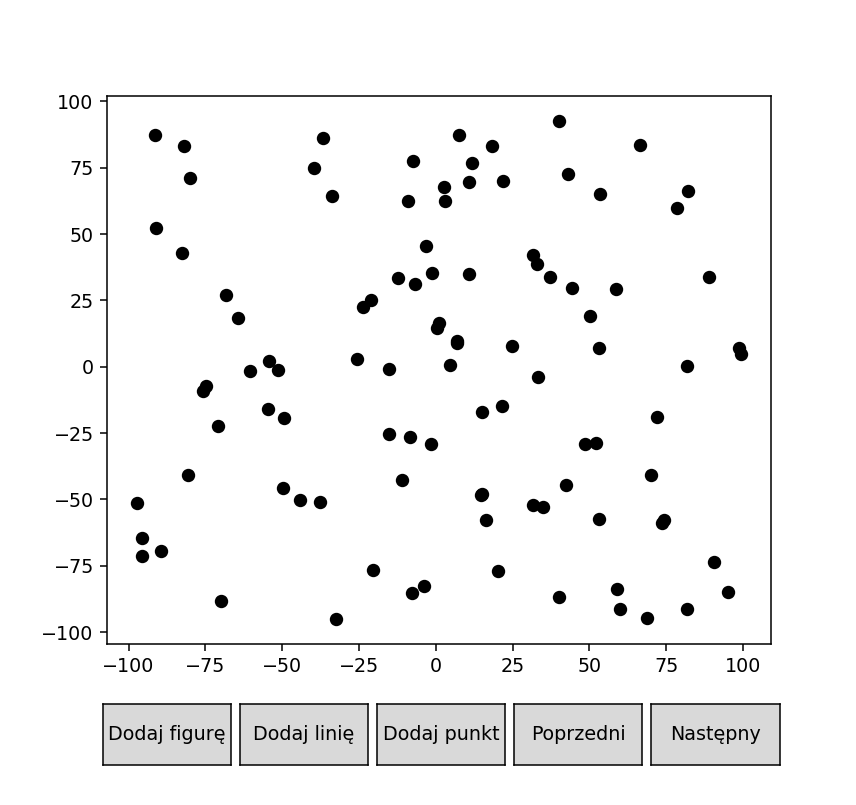

In [56]:
plot = Plot(points=[PointsCollection(pointsA,color='black')])        
plot.draw()

<IPython.core.display.Javascript object>


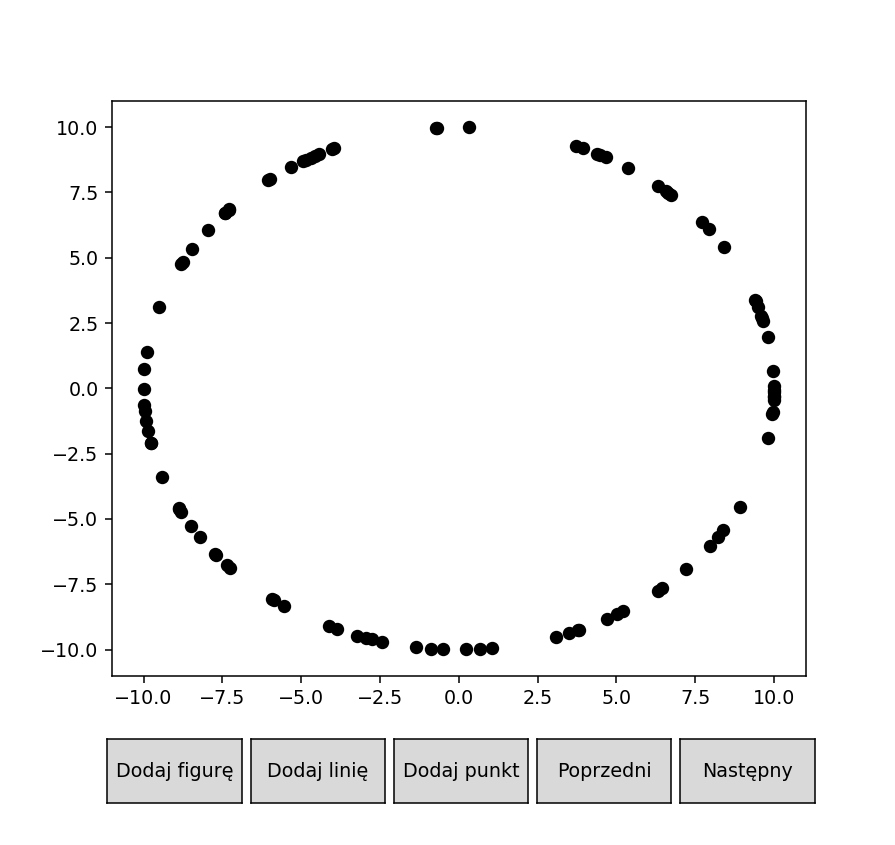

In [57]:
plot = Plot(points=[PointsCollection(pointsB,color='black')])        
plot.draw()

<IPython.core.display.Javascript object>


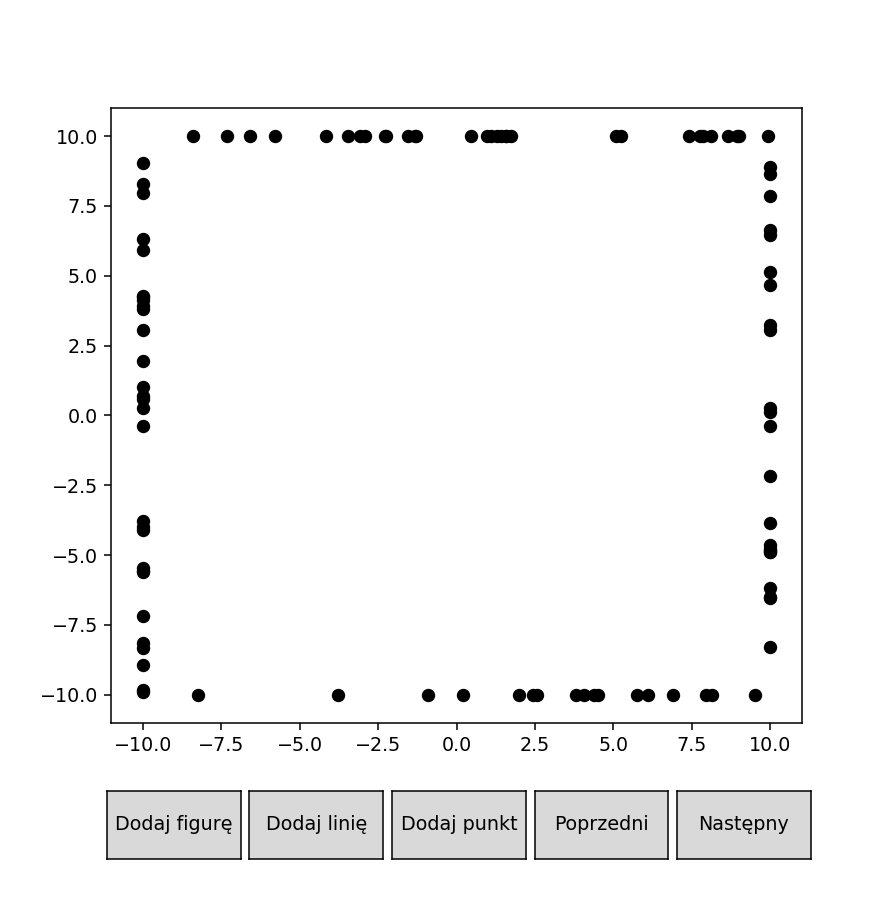

In [60]:
plot = Plot(points=[PointsCollection(pointsC,color='black')])        
plot.draw()

<IPython.core.display.Javascript object>


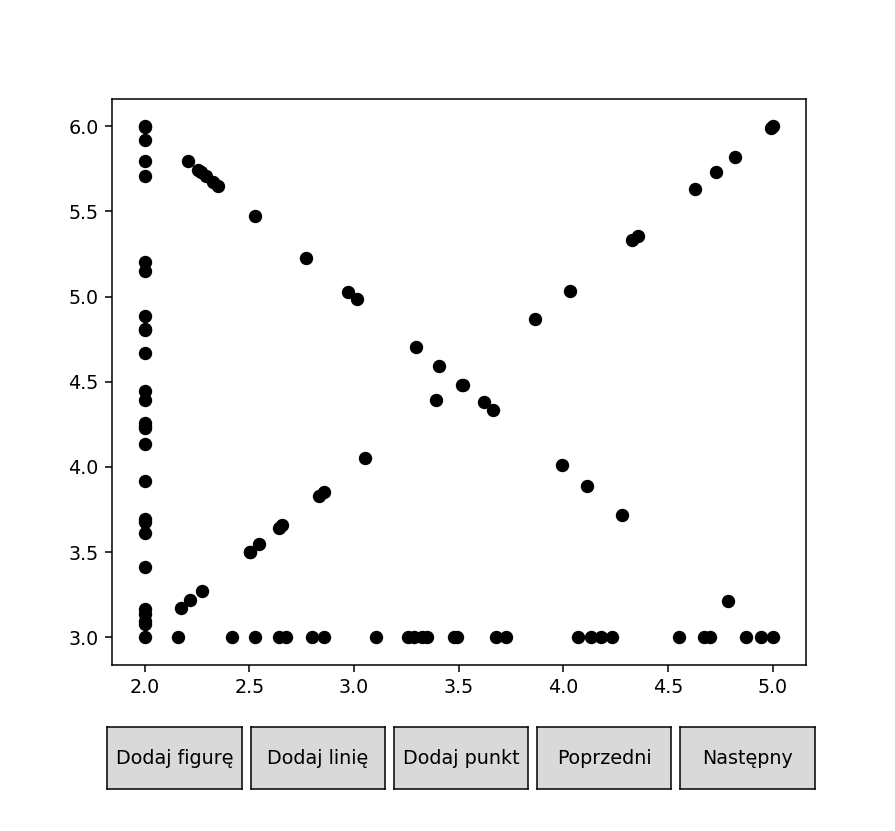

In [61]:
plot = Plot(points=[PointsCollection(pointsD,color='black')])        
plot.draw()

<IPython.core.display.Javascript object>


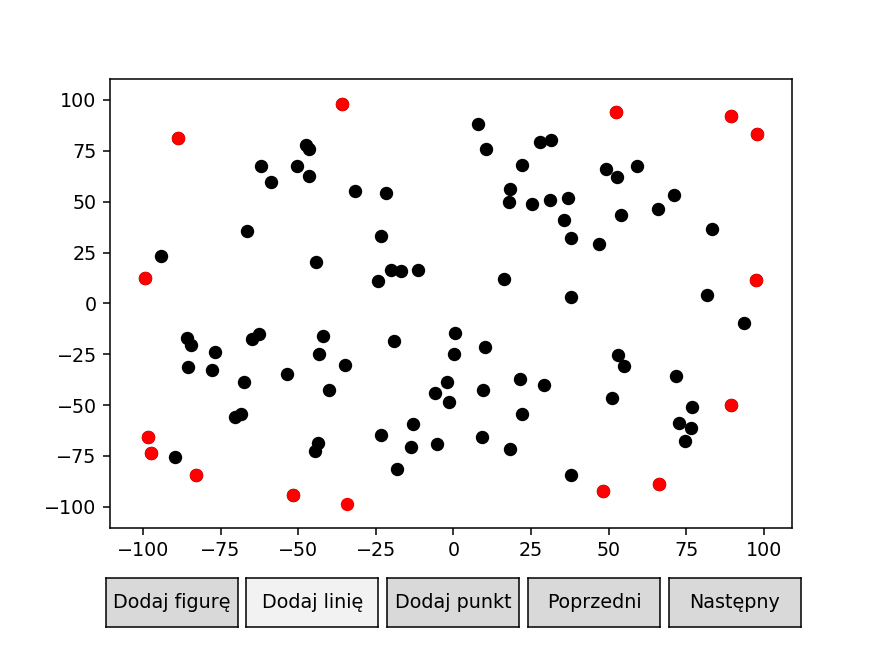

In [11]:
points = pointsA.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Graham(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


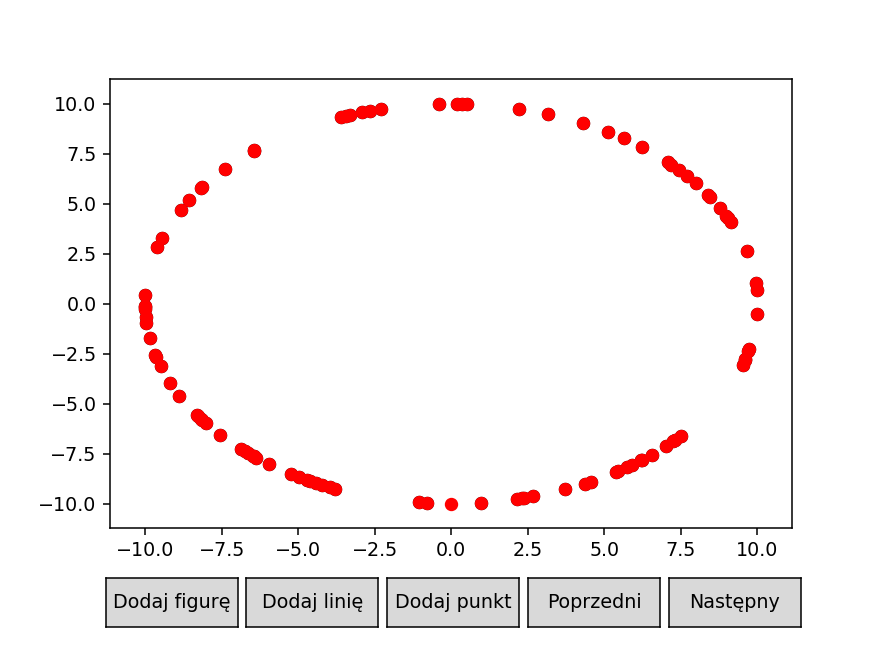

In [12]:
points = pointsB.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Graham(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


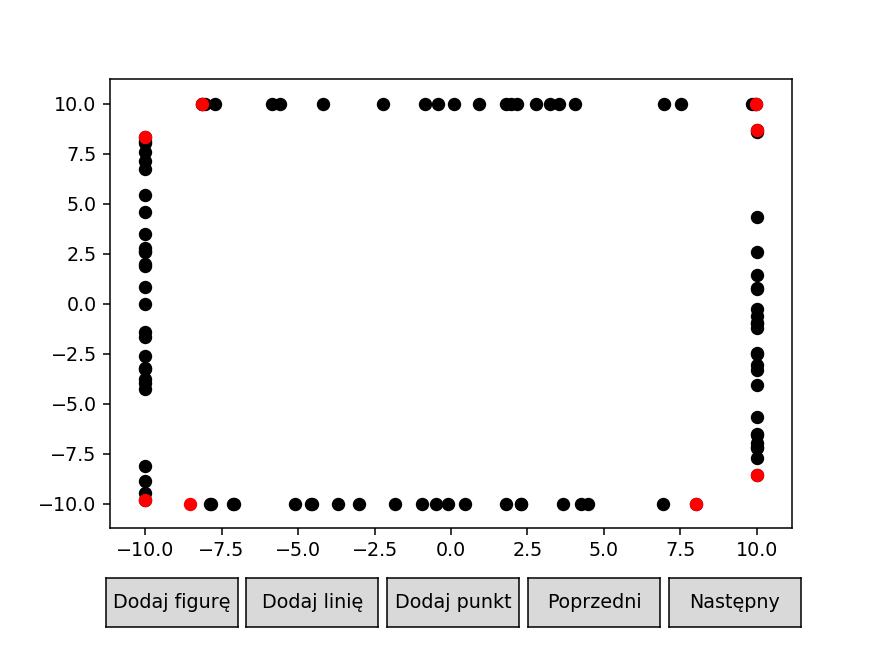

In [13]:
points = pointsC.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Graham(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


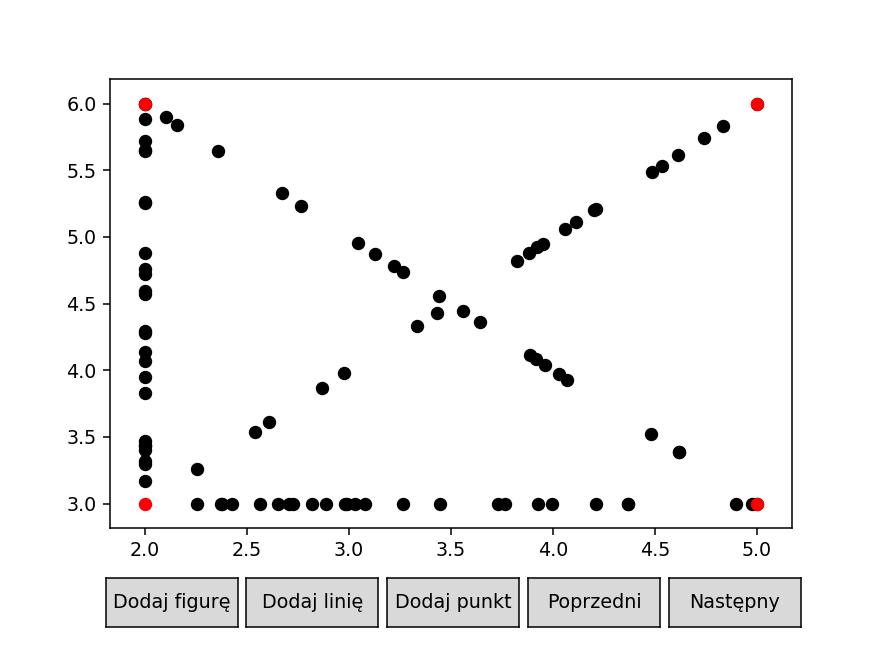

In [14]:
points = pointsD.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Graham(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


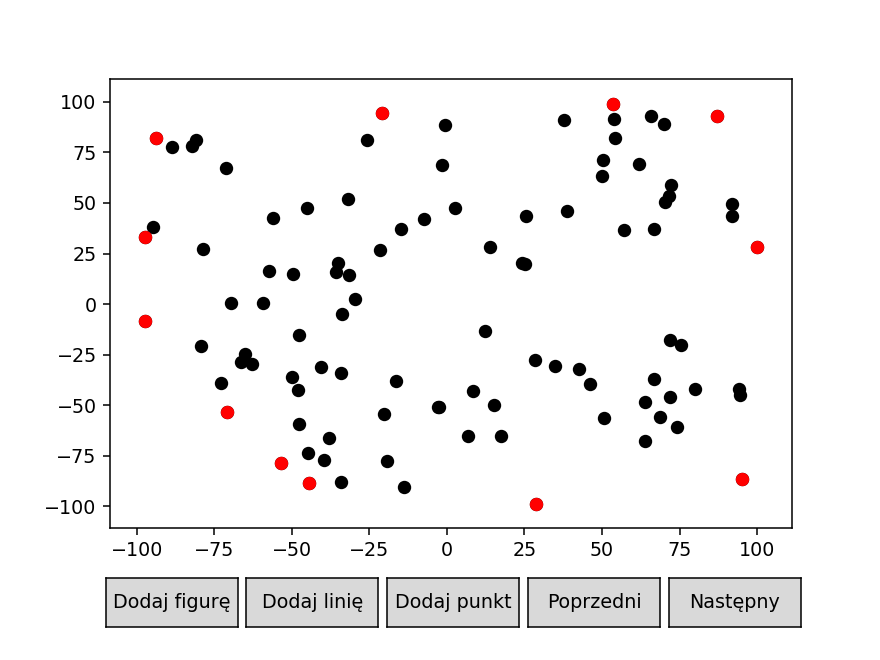

In [167]:
points = pointsA.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Jarvis(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


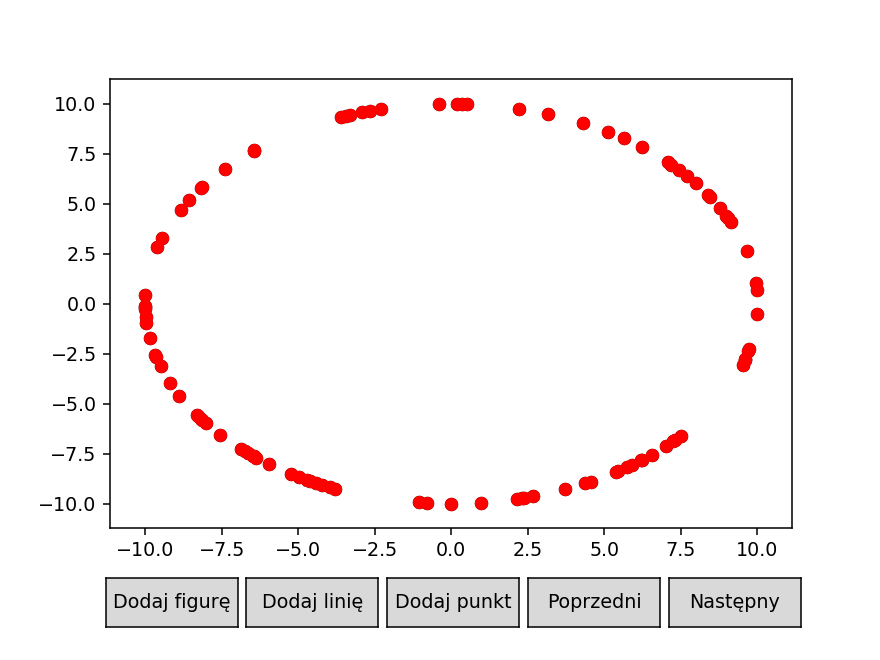

In [15]:
points = pointsB.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Jarvis(points),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


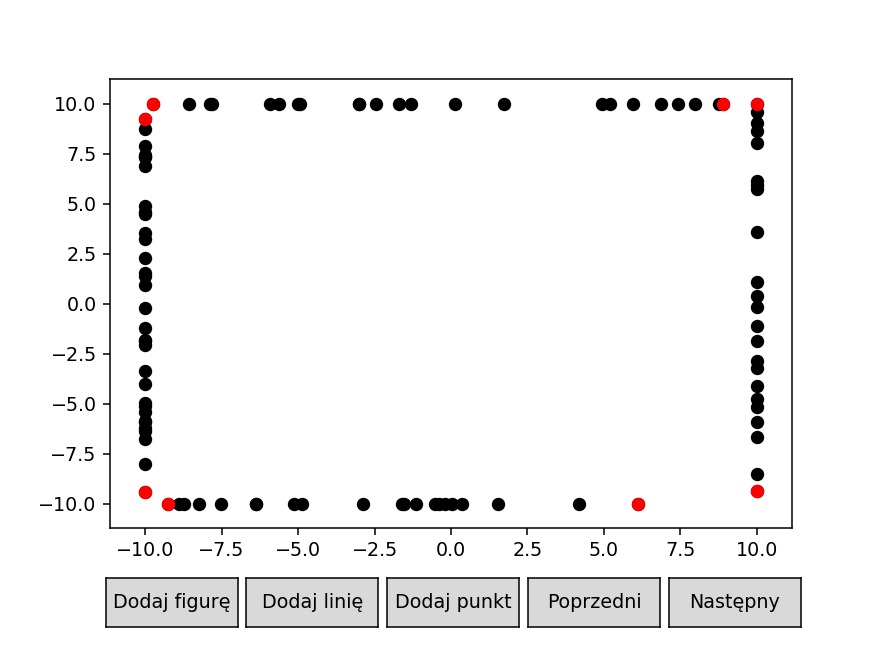

In [22]:
plot = Plot(points=[PointsCollection(pointsC,color='black'),PointsCollection(Jarvis(pointsC),color='red')])        
plot.draw()

<IPython.core.display.Javascript object>


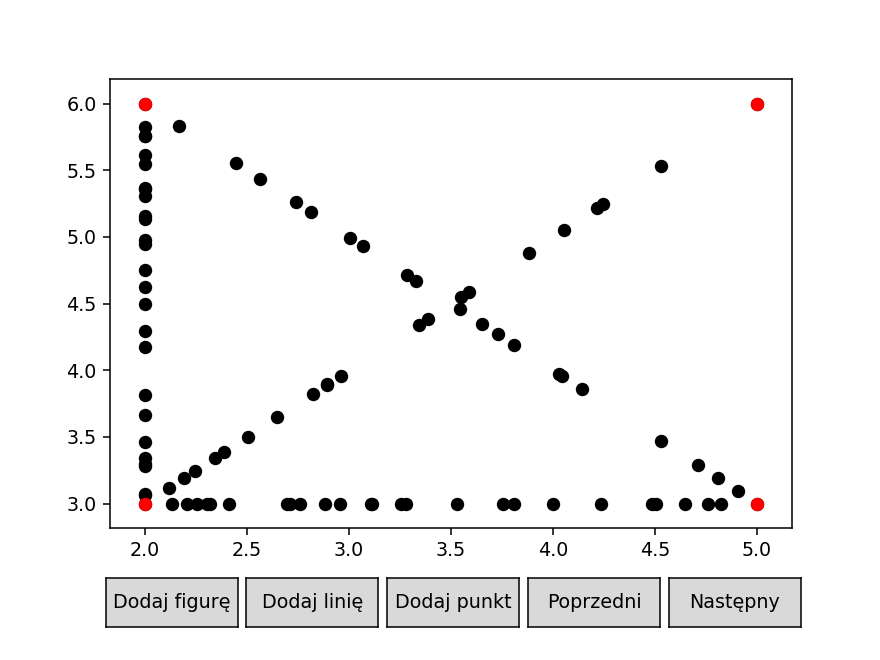

In [170]:
points = pointsD.copy()
plot = Plot(points=[PointsCollection(points,color='black'),PointsCollection(Jarvis(points),color='red')])        
plot.draw()

In [5]:
#WIZUALIZACJA GRAHAMA

#funckja zwraca scene z aktualnym stackiem
#podczas tworzenia scen w funckji na podstawie stacka otrzymywany byl zawsze koncowy wynik
#dlatego do przechowywania tez posrednich wartosci stacka zostala utworzona osobna funkcja
def stackAtMoment(stack,points):
    result = []
    for el in stack:
        result.append(el)
    lines = stackToLines(stack)
        
    return Scene([PointsCollection(points, color = 'black'),PointsCollection(result, color = 'red')],[LinesCollection(lines)])

#tworzenie linii nalezacej do otoczki aktualnie rozpatrywanej
def stackToLines(stack):
    lines = []
    for i in range (len(stack)-1):
        lines.append([stack[i],stack[i+1]])
    return lines


#zwraca scene z pelna otoczka na podstawie uzyskanego stacka
def fullHull(stack,points):
    lines = stackToLines(stack)
    lines.append([stack[0],stack[len(stack)-1]])
    return Scene([PointsCollection(points, color = 'black'),PointsCollection(stack, color = 'red')],[LinesCollection(lines)])

#wizualizacja grahama
#zostala utowrzona nowa funkcja aby wizualizacja nie wplywala na pobierane wyniki czasu trwania algorytmu
def makeSceneGraham(points):
    pointsAll = points.copy()
    
    scenes = [Scene([PointsCollection(pointsAll, color='black')])]
    
    #szukanie punktu o najmniejszej wspolrzednej y (i x)
    p0 = min(points, key = lambda x: comp(x))
            
    scenes.append(Scene([PointsCollection(pointsAll, color='black'),PointsCollection([p0], color='red')]))
    #usuniecie punktu z listy
    points.remove(p0)
    

    #sortowanie pozostalych punktow ze wzgledu na wielkosc kata
    Quicksort(points,0,len(points)-1,p0)
    
    #usuniecie punktow o takiej samej wartosci kata i mniejszej odleglosci
    i = 0
    j = 1
    remove = [] #przechowywanie indeksow do usuniecia
    
    while(j<len(points)):
        prod = cross_prod(p0,points[i],points[j]) 
        if prod <= (epsilon) and prod >= -(epsilon):
            if distanceBetweenPoints(p0,points[i]) >= distanceBetweenPoints(p0,points[j]):
                remove.append(j)
                j+=1
            else:
                remove.append(i)
                i = j
                j+=1
        else:
            i = j
            j+=1
    
    removePoints = []
    for el in remove:
        removePoints.append(points[el])
   
    points = [ i for j, i in enumerate(points) if j not in remove] #usuniecie punktow po indeksie
    
    scenes.append(Scene([PointsCollection([p0], color='red'),PointsCollection(removePoints, color='yellow'), PointsCollection(points, color='black')]))
        
    #pusty stack
    stack = []
    
    
    #do stacka dajemy punkt p0 i 2 poczatkowe punkty
    stack.append(p0)
    stack.append(points[0])
    stack.append(points[1])
    
    #stack na linie
    stackLines = [[p0,points[0]],[points[0],points[1]]]

    
    i = 2 
   
    scenes.append(stackAtMoment(stack,points))
        
    while(i < len(points)):
        if cross_prod(stack[len(stack)-1],stack[len(stack)-2],points[i]) < -10**(-9):
            stack.append(points[i])
            stackLines+=([stack[len(stack)-1],points[i]])
            i+=1
        else:
            stack.pop()
            
        scenes.append(stackAtMoment(stack,points))
            
    scenes.append(fullHull(stack,pointsAll)) 
            
    
    return scenes

points = pointsC.copy()
scenes = makeSceneGraham(points)
plot = Plot(scenes = scenes)
plot.draw()




NameError: name 'Scene' is not defined

<IPython.core.display.Javascript object>


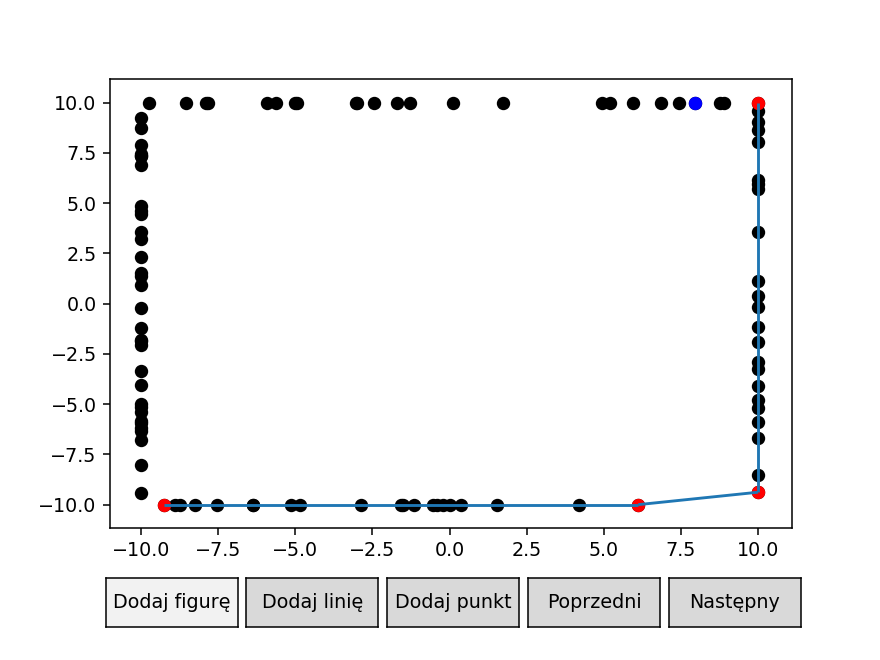

In [24]:
#WIZUALIZACJA JARVISA

#funckja do tworzenia scen z rozpatrywanym aktualnie punktem - zaznaczony bedzie na kolor niebieski
def sceneOfchoosingPoint(stack,points,point):
    result = []
    for el in stack:
        result.append(el)
    lines = stackToLines(stack)
        
    return Scene([PointsCollection(points, color = 'black'),PointsCollection(result, color = 'red'),PointsCollection([point], color = 'blue')],[LinesCollection(lines)])
    
#wizualizacja Jarvisa
def makeSceneJarvis(points):
    pointsAll = points.copy()
    scenes = [Scene([PointsCollection(pointsAll, color='black')])]
    
    #szukanie punktu o najmniejszej wspolrzednej y (i x)
    p0 = min(points, key = lambda x: comp(x))
    i0 = points.index(p0)
    
    i = i0 #indeks
    
    
    Hull = [p0]
    scenes.append(Scene([PointsCollection(points, color='black'),PointsCollection([p0], color='red')]))
    
    while True:
        k = (i+1) % len(points)
        
        for j in range (len(points)):   #for j ≠ i do
            
            if j == i:
                continue
            #szukamy punkt, dla którego kąt liczony przeciwnie do
            #wskazówek zegara w odniesieniu do ostatniej krawędzi
            #otoczki jest najmniejszy
            
            prod = cross_prod(points[i], points[j], points[k])
            if prod > epsilon or (prod <= epsilon and prod >= -epsilon and distanceBetweenPoints(points[j], points[i]) > distanceBetweenPoints(points[k], points[i])):
                scenes.append(sceneOfchoosingPoint(Hull,points,points[j]))
                k = j
            
        i = k
        
        if i == i0:
            break
        
        Hull.append(points[k])
        scenes.append(stackAtMoment(Hull,points))
        
    scenes.append(fullHull(Hull,pointsAll))
        
    return scenes


points = pointsC.copy()
scenes = makeSceneJarvis(points)
plot = Plot(scenes = scenes)
plot.draw()


In [6]:
#Masowe uruchamianie testow oraz zbieranie wynikow czasow dzialania algorytmow dla roznych danych

import time


#Dane testowane:

#A
nA = [50,100,500,1000,1500,2000,2500]
nStart = [-10,-100,-1000]
nEnd = [10,100,1000]

#B
nB = [50,100,500,1000,1500,2000,2500]
r = [1,10,100,200]
sX = 0
sY = 0

#C

nC = [50,100,500,1000,1500,2000,2500]
w1C = [[-10,-10],[-100,-100],[-200,-200],[-300,-300]]
w2C = [[10,10],[100,100],[200,200],[300,300]]

#D
nside = [25,100,250,500,750,1000,1250]
ndiag = [20,100,250,500,750,1000,1250]
w1D = [2,3]
w2D = [5,6]

#Funkcje testowane
hullMakers = [Graham,Jarvis]

#Funkcje gromadzace dane z kazdego zbioru punktow
def letTheTestBeginA(hullMakers,nA,nStart,nEnd):
    
    result = [[[] for i in range (len(nA))] for j in range (2)]
    
    for k in range (2):
        for i in range (len(nA)):
            helper = "Liczba punktow: " + str(nA[i])
            result[k][i].append(helper)
            for x in range (len(nStart)):

                pointsA = generatePointsA(nA[i],nStart[x],nEnd[x]) #generowanie stosownych punktow

                start_time = time.time()

                hullMakers[k](pointsA)

                result[k][i].append(time.time() - start_time)
        
    return result


def letTheTestBeginB(hullMakers,nB,r,sX,sY):
    
    result = [[[] for i in range (len(nB))] for j in range (2)]
    
    for k in range (2):
        for i in range (len(nB)):
            helper = "Liczba punktow: " + str(nB[i])
            result[k][i].append(helper)
            for x in range (len(r)):

                pointsB = generatePointsB(nB[i],r[x],sX,sY) #generowanie stosownych punktow

                start_time = time.time()

                hullMakers[k](pointsB)

                result[k][i].append(time.time() - start_time)
        
    return result

def letTheTestBeginB(hullMakers,nB,r,sX,sY):
    
    result = [[[] for i in range (len(nB))] for j in range (2)]
    
    for k in range (2):
        for i in range (len(nB)):
            helper = "Liczba punktow: " + str(nB[i])
            result[k][i].append(helper)
            for x in range (len(r)):

                pointsB = generatePointsB(nB[i],r[x],sX,sY) #generowanie stosownych punktow

                start_time = time.time()

                hullMakers[k](pointsB)

                result[k][i].append(time.time() - start_time)
        
    return result

def letTheTestBeginC(hullMakers,nC,w1C,w2C):
    
    result = [[[] for i in range (len(nC))] for j in range (2)]
    
    for k in range (2):
        for i in range (len(nC)):
            helper = "Liczba punktow: " + str(nC[i])
            result[k][i].append(helper)
            
            for x in range (len(w1C)):
                
                pointsC = generatePointsC(nC[i],w1C[x],w2C[x])
                
                start_time = time.time()

                hullMakers[k](pointsC)

                result[k][i].append(time.time() - start_time)

    return result
                

def letTheTestBeginD(hullMakers,nside,ndiag,w1D,w2D):
    result = [[[] for i in range (len(ndiag))] for j in range (2)]
    
    for k in range (2):
        for i in range (len(ndiag)):
            helper = "Ndiag: " + str(ndiag[i])
            result[k][i].append(helper)
            
            for x in range (len(nside)):
                
                pointsD = generatePointsD(nside[x],ndiag[i],w1D,w2D)
                
                start_time = time.time()

                hullMakers[k](pointsD)

                result[k][i].append(time.time() - start_time)

    return result
    
    


List = [[] for i in range (4)]

List.append(letTheTestBeginA(hullMakers,nA,nStart,nEnd))

List.append(letTheTestBeginB(hullMakers,nB,r,sX,sY))

List.append(letTheTestBeginC(hullMakers,nC,w1C,w2C))

List.append(letTheTestBeginD(hullMakers,nside,ndiag,w1D,w2D))


with open ("wynik.csv",'w') as handle:
       
    for list in List:
        csvwriter = csv.writer(handle)
        csvwriter.writerow(list)     #zapis do pliku otrzymanej listy punktow nalezacych do otoczki





In [7]:
#Test czy kształt prostokąta wpływa na 
import time

result = [[[],[],[]],[[],[],[]]]

nC = 1000
w1C = [[0,0],[0,0],[0,0]]
w2C = [[1000,10],[100,100],[10,1000]]

for i in range(2):
    for j in range(3):
    
        pointsC = generatePointsC(nC,w1C[j],w2C[j])
        
        start_time = time.time()
        hullMakers[i](pointsC)
        result[i][j].append(time.time() - start_time)
        
print(result)





[[[0.08003711700439453], [0.06777644157409668], [0.06701326370239258]], [[0.019080162048339844], [0.01897597312927246], [0.016781091690063477]]]
